# In this lab, you will understand how to acheive conversational RAG

In [ ]:
pip install langchain-huggingface langchain_core langchain_openai  langchain_community faiss-cpu pypdf gradio python-dotenv bs4

In [ ]:
pip install fastapi nest-asyncio pyngrok uvicorn



**Open .env file in this folder and observe that we have configured OPENAI_API_KEY. Replace it with your own key or key given by me**

The Code in the below cell will load the .env file and set environment variables.

**Write the code in the below cell and execute it**

In [6]:
from langchain_core.documents import Document
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from dotenv import load_dotenv

load_dotenv()

True

In [7]:

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

**Below code is loading data from a web URL into FAISS Vector Store**

**Understand the below code and execute it**

In [14]:
from langchain_community.document_loaders.pdf import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEmbeddings




#loader = PyPDFLoader(file_path="drive/MyDrive/Colab Notebooks/ds-book.pdf")
loader = PyPDFLoader(file_path="employee-handbook.pdf")
documents = loader.load()

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=30, separator="\n")
splits = text_splitter.split_documents(documents=documents)


vectorstore = FAISS.from_documents(documents=splits, embedding=HuggingFaceEmbeddings())
retriever = vectorstore.as_retriever()


**Observe the below code and understand how we are creating RAG Chain using the retriever**

**Execute it. and observe the result**

In [31]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains.combine_documents.stuff import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain_core.prompts import MessagesPlaceholder


message = """
Answer this question using the provided context only. If you dont know the answer, just say 'I dont know'
{input}
Context:
{context}
"""

prompt = ChatPromptTemplate.from_messages([
     MessagesPlaceholder("chat_history"),
    ("human", message)

    ]
    )
llm = ChatOpenAI(model="gpt-4o-mini")



question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)
chat_history= []
input=  """Give me the policy names related to employee attendance , punctuality and conflict of interest.
    Give me only names as list"""

response = rag_chain.invoke({
    "chat_history":chat_history,
    "input" : input
})



print(response["answer"])

- General Attendance
- Tardiness
- Conflict of Interest (not explicitly listed, but can be inferred from the context)


**Execute below code and observe that this Rag chain doesnot give expected response to a followup question . It is not conversational**

In [32]:
from langchain_core.messages import AIMessage, HumanMessage
chat_history= []
chat_history.extend(
    [
    HumanMessage(content=input),
    AIMessage(content=response["answer"])
    ]
)

response = rag_chain.invoke({
    "chat_history":chat_history,
    "input" : """Can you elaborate about those points
                and give me response as bullet points in different lines"""
})


print(response['answer'])

- Companies may consider instituting a Confidentiality policy.
- A Conflict of Interest policy is important for maintaining ethical standards.
- Intellectual Property Ownership is crucial for protecting company assets.
- Policies on Outside Employment can prevent conflicts with company goals.
- Companies may offer Additional Benefits, such as Training or Education Reimbursement.
- Expense Reporting policies help in managing company expenses.
- Guidelines for the Use of Company Vehicles ensure safety and proper usage.
- A policy specific to computer systems should protect against employee misuse and viruses.
- Employees are expected to act in a professional manner and fulfill job responsibilities.
- Performance reviews evaluate various factors including attendance and punctuality.  
- Performance reviews can influence pay increases, promotions, and terminations.
- Written performance evaluations can be issued at any time to address unacceptable performance.
- Changes in employment statu

**The response doesnot contain relevant details**

# Maitinaining history in conversation

**We need a retriever which maintains the chat_history and will create one standalone question from the history and use it as a system message**

**Observe the below code and understan how we are creating history aware retriever**

**Execute the below code**

In [35]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_prompt =  """Given above  chat history and the below  latest user question
    which might reference context in the chat history,
    formulate a standalone question which can be understood
    without the chat history. Do NOT answer the question,
    just reformulate it if needed and otherwise return it as is.
    Below is the latest  question:

    {input}
    """


contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
       # ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", f"""{contextualize_q_prompt}""" ),

    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

result=history_aware_retriever.invoke(
    {
    "chat_history":chat_history,
    "input" : """Can you elaborate about those points
                and give me response as bullet points in different lines"""

)

# result
#history_aware_retriever.invoke({"input":"What is Task Decomposition?"})
#history_aware_retriever.invoke({"input":"how can we achieve it?"})

**Observe the below code and understand how we are using history_aware_retriever to create a retrieval chain.**

**Also Observe that we have added chat_history variable in the prompt template**

**Execute the below code**

In [36]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain




qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", (
                        """You are an assistant for question-answering tasks.
                        "Answer this question using the provided context only.
                        If you dont know the answer, just say 'I dont know'
                        {context}"""
                    )),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

contextual_rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


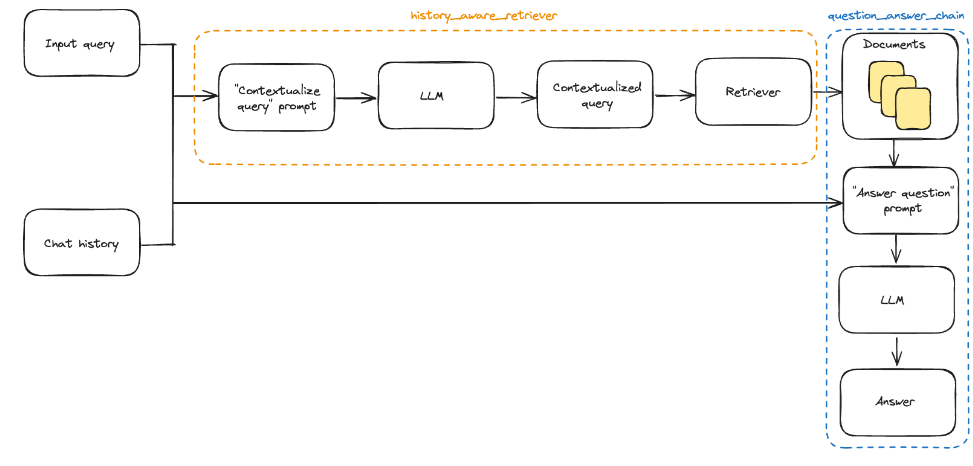


**Below code is managing the chat history manually.**

**Understand the below code and execute it**

In [38]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []




question = """Give me the policy names related to employee attendance , punctuality and conflict of interest.
    Give me only names as list"""
print(question)
ai_msg_1 = contextual_rag_chain.invoke({"input": question, "chat_history": chat_history})
print(ai_msg_1["answer"])

chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "Can you elaborate about those points and give me response as bullet points in different lines"
print(second_question)
ai_msg_2 = contextual_rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

Give me the policy names related to employee attendance , punctuality and conflict of interest. 
    Give me only names as list
1. General Attendance  
2. Tardiness  
3. Breaks  
Can you elaborate about those points and give me response as bullet points in different lines
- **General Attendance**: The company maintains normal working hours of 8 a.m. to 5 p.m., which may vary depending on work location and job responsibilities. Employees must notify a supervisor in advance of any tardiness or absenteeism, and chronic absenteeism may lead to disciplinary action.

- **Tardiness**: Employees are expected to arrive on time and ready for work. Arriving 5 minutes after the scheduled time is considered tardy.

- **Breaks**: (No details provided in the context regarding breaks; I cannot elaborate.)


**Below code uses RunnableWithMessageHistory to maintain history automatically based on session_id**

**Understand the below code and execute it**

In [39]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain = RunnableWithMessageHistory(
    contextual_rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

**Invoke the chain 2 times with same session id and observe that the chain remembers the previous messages in the conversation**



In [40]:
response=conversational_rag_chain.invoke(
    {"input": "What policies does the handbook include about employee attendance and punctuality? Just give ploicy names"},
    config={
        "configurable": {"session_id": "abc1235"}
    },  # constructs a key "abc123" in `store`.
)
print(response["answer"])

The policies included about employee attendance and punctuality are:

1. General Attendance
2. Tardiness


In [41]:
response= conversational_rag_chain.invoke(
    {"input": "Can you elaborate about those points and give me response as bullet points in different lines"},
    config={"configurable": {"session_id": "abc1235"}},
)

print(response["answer"])

- **General Attendance**: 
  - Employees are expected to adhere to normal working hours, typically from 8 a.m. to 5 p.m. 
  - Work hours may vary based on location and job responsibilities.
  - Supervisors will communicate individual work schedules to employees.
  - Employees should notify supervisors in advance if they are going to be late or absent.
  - Chronic absenteeism may lead to disciplinary action.
  - Employees must inform supervisors before leaving early; unauthorized departures may result in disciplinary action.

- **Tardiness**: 
  - Employees are expected to arrive on time and ready for work.
  - Arriving 5 minutes after the scheduled arrival time is considered tardy.


**Run the below code to see all the messages in the chat history**

In [42]:
for message in store["abc1235"].messages:
    if isinstance(message, AIMessage):
        prefix = "AI"
    else:
        prefix = "User"

    print(f"{prefix}: {message.content}\n")

User: What policies does the handbook include about employee attendance and punctuality? Just give ploicy names

AI: The policies included about employee attendance and punctuality are:

1. General Attendance
2. Tardiness

User: Can you elaborate about those points and give me response as bullet points in different lines

AI: - **General Attendance**: 
  - Employees are expected to adhere to normal working hours, typically from 8 a.m. to 5 p.m. 
  - Work hours may vary based on location and job responsibilities.
  - Supervisors will communicate individual work schedules to employees.
  - Employees should notify supervisors in advance if they are going to be late or absent.
  - Chronic absenteeism may lead to disciplinary action.
  - Employees must inform supervisors before leaving early; unauthorized departures may result in disciplinary action.

- **Tardiness**: 
  - Employees are expected to arrive on time and ready for work.
  - Arriving 5 minutes after the scheduled arrival time is